# Running PICS finemapping on Finngen summary statistics

1. Read summary stats.
2. Apply window based clumping.
3. LD expansion.
4. lD clumping.
5. PICS.

In [1]:
# Import:
from pyspark.sql import functions as f

from gentropy.common.session import Session
from gentropy.dataset.ld_index import LDIndex
from gentropy.dataset.study_index import StudyIndex
from gentropy.dataset.study_locus import StudyLocus
from gentropy.dataset.summary_statistics import SummaryStatistics
from gentropy.method.ld import LDAnnotator
from gentropy.method.pics import PICS

# Initialize session:
session = Session()

# Input:
sumstats = "gs://genetics_etl_python_playground/output/python_etl/parquet/XX.XX/preprocess/finngen/summary_stats/*"
ld_index_path = "gs://genetics_etl_python_playground/output/python_etl/parquet/XX.XX/ld_index/"

# Parameters:
clump_window_length = 500_000  # Distance between semi-indices.
locus_window_length = 250_000  # Distance around semi-indices from where the tags are collected.

# Output:
window_based_clumped_output = "gs://ot-team/dsuveges/finngen/2023.10.13_window_clumped_w_locus"
ld_clumped_output = "gs://ot-team/dsuveges/finngen/2023.10.13_ld_clumped_w_locus"
picsed_output = "gs://ot-team/dsuveges/finngen/2023.10.06_PICSed"


Loading BokehJS ...

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/13 09:53:40 INFO SparkEnv: Registering MapOutputTracker
23/10/13 09:53:40 INFO SparkEnv: Registering BlockManagerMaster
23/10/13 09:53:40 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
23/10/13 09:53:40 INFO SparkEnv: Registering OutputCommitCoordinator
23/10/13 09:53:42 WARN GhfsStorageStatistics: Detected potential high latency for operation op_get_file_status. latencyMs=198; previousMaxLatencyMs=0; operationCount=1; context=gs://dataproc-temp-europe-west1-426265110888-ymkbpaze/64dcfdf8-46d3-4b5c-aad4-0a12ee0ba91a/spark-job-history
23/10/13 09:53:42 WARN GhfsStorageStatistics: Detected potential high latency for operation op_mkdirs. latencyMs=166; previousMaxLatencyMs=0; operationCount=1; context=gs://dataproc-temp-europe-west1-426265110888-ymkbpaze/64dcfdf8-46d3-4b5c-aad4-0a12ee0ba91a/spark-job-history


## 1. Read summary statistics

In [16]:
finngen_sumstats = SummaryStatistics(
    _df=(
        session.spark.read.parquet(sumstats, recursiveFileLookup=True)
        # We need to add chromosome column as this is a partition column:
        .withColumn("chromosome",f.split(f.col("variantId"), "_")[0])
    ),
    _schema=SummaryStatistics.get_schema()
)
finngen_sumstats.df.show()

23/10/06 08:46:37 WARN GhfsStorageStatistics: Detected potential high latency for operation stream_read_operations. latencyMs=236; previousMaxLatencyMs=147; operationCount=276; context=gs://genetics_etl_python_playground/output/python_etl/parquet/XX.XX/preprocess/finngen/summary_stats/FINNGEN_R9_AB1_ACTINOMYCOSIS/chromosome=1/part-00011-33e31f88-435f-4200-9adc-3e909d706910.c000.snappy.parquet
23/10/06 08:46:37 WARN GhfsStorageStatistics: Detected potential high latency for operation stream_read_operations. latencyMs=269; previousMaxLatencyMs=236; operationCount=282; context=gs://genetics_etl_python_playground/output/python_etl/parquet/XX.XX/preprocess/finngen/summary_stats/FINNGEN_R9_HEIGHT_IRN/chromosome=2/part-00020-774f0990-ad3d-46ae-9648-f39c18fae314.c000.snappy.parquet
23/10/06 08:46:38 WARN GhfsStorageStatistics: Detected potential high latency for operation stream_read_operations. latencyMs=417; previousMaxLatencyMs=269; operationCount=288; context=gs://genetics_etl_python_playg

+--------------------+-----------+--------+--------------+--------------+-----------+-------------+-------------------------------+---------------------------+---------------------------+----------+
|             studyId|  variantId|position|pValueMantissa|pValueExponent|       beta|standardError|effectAlleleFrequencyFromSource|betaConfidenceIntervalLower|betaConfidenceIntervalUpper|chromosome|
+--------------------+-----------+--------+--------------+--------------+-----------+-------------+-------------------------------+---------------------------+---------------------------+----------+
|FINNGEN_R9_HEIGHT...|2_10603_A_C|   10603|         8.515|            -1|  0.0117813|    0.0629271|                     2.30629E-4|                 -0.0511458|                  0.0747084|         2|
|FINNGEN_R9_HEIGHT...|2_10610_G_A|   10610|         8.814|            -3|  0.0187529|   0.00715985|                      0.0194828|                 0.01159305|                 0.02591275|         2|
|FINN

## 2. Apply window based clumping.

- Clumping distance: +/-500kbp
- Locus collected: +/-250kbp

In [34]:
# This process takes ~1h on a 32 cores:
(
    SummaryStatistics(
        _df=(
            session.spark.read.parquet(sumstats, recursiveFileLookup=True)
            .withColumn(
                "chromosome",
                f.split(f.col("variantId"), "_")[0]
            )
        ),
        _schema=SummaryStatistics.get_schema()
    )
    .window_based_clumping(
        distance=clump_window_length,
        locus_collect_distance=locus_window_length,
        with_locus=True
    )
    .df.write.mode("overwrite")
    .parquet(window_based_clumped_output)
)

23/10/06 10:22:32 WARN GhfsStorageStatistics: Detected potential high latency for operation stream_write_close_operations. latencyMs=1812; previousMaxLatencyMs=253; operationCount=415; context=gs://ot-team/dsuveges/finngen/2023.10.06_window_clumped/_temporary/0/_temporary/attempt_202310061022254599137247441201519_0051_m_000011_106753/part-00011-53e48f6d-d432-40c5-9201-d4c8f03e6dee-c000.snappy.parquet


## 3. LD expansion

- For FINNGEN, study table needs to be mocked.

In [8]:
# Generating a "fake" study index, just for providing ld_population structure for each finngen study:
studies_df = (
    session.spark.read.parquet("gs://ot-team/dsuveges/finngen_semi_indices_250kbp")
    # Generating a list of study identifiers:
    .select("studyId")
    .distinct()
    # Adding fabricated values required to parse as gwas catalog study:
    .select(
        "studyId",
        StudyIndex.aggregate_and_map_ancestries(
            f.array(
                f.struct(
                    f.lit("Finnish").alias("ancestry"),
                    f.lit(100).cast("long").alias("sampleSize")
                )
            )
        ).alias("ldPopulationStructure"),
        f.lit("FINNGEN").alias("projectId"),
        f.lit("gwas").alias("studyType"),
        f.lit("cicaful").alias("traitFromSource")
    )
)

study_index = (
    StudyIndex(
        _df=studies_df,
        _schema=StudyIndex.get_schema()
    )
)

study_index.df.show()

+--------------------+---------------------+---------+---------+---------------+
|             studyId|ldPopulationStructure|projectId|studyType|traitFromSource|
+--------------------+---------------------+---------+---------+---------------+
|FINNGEN_R9_K11_EN...|         [{fin, 1.0}]|  FINNGEN|     gwas|        cicaful|
|FINNGEN_R9_P16_IN...|         [{fin, 1.0}]|  FINNGEN|     gwas|        cicaful|
| FINNGEN_R9_C_STROKE|         [{fin, 1.0}]|  FINNGEN|     gwas|        cicaful|
|FINNGEN_R9_G6_HER...|         [{fin, 1.0}]|  FINNGEN|     gwas|        cicaful|
|FINNGEN_R9_RHEUMA...|         [{fin, 1.0}]|  FINNGEN|     gwas|        cicaful|
|FINNGEN_R9_N14_EN...|         [{fin, 1.0}]|  FINNGEN|     gwas|        cicaful|
|     FINNGEN_R9_PAIN|         [{fin, 1.0}]|  FINNGEN|     gwas|        cicaful|
|FINNGEN_R9_D3_COA...|         [{fin, 1.0}]|  FINNGEN|     gwas|        cicaful|
|FINNGEN_R9_F5_UNSORG|         [{fin, 1.0}]|  FINNGEN|     gwas|        cicaful|
|FINNGEN_R9_HEIGHT...|      

In [19]:
# Loading ld index:
ld_index = LDIndex.from_parquet(session, ld_index_path)



## 4. LD based clumping.

- Persist resulting dataset.
- Save dataset.

In [20]:
(
    # To annotate study/locus, study level info and ld panel is needed:
    LDAnnotator.ld_annotate(
        StudyLocus.from_parquet(session, window_based_clumped_output),
        study_index,
        ld_index
    )
    # Clumping linked study-loci together:
    .clump()
    .df.write.mode("overwrite").parquet(ld_clumped_output)
)



23/10/06 09:11:42 WARN GhfsStorageStatistics: Detected potential high latency for operation stream_read_operations. latencyMs=1312; previousMaxLatencyMs=1306; operationCount=59583672; context=gs://genetics_etl_python_playground/output/python_etl/parquet/XX.XX/preprocess/finngen/summary_stats/FINNGEN_R9_RX_N05C/chromosome=1/part-00012-a13aba14-79f4-45c0-9af0-937d599fa3f0.c000.snappy.parquet
23/10/06 09:11:43 WARN GhfsStorageStatistics: Detected potential high latency for operation stream_read_operations. latencyMs=1316; previousMaxLatencyMs=1312; operationCount=59631953; context=gs://genetics_etl_python_playground/output/python_etl/parquet/XX.XX/preprocess/finngen/summary_stats/FINNGEN_R9_RX_CODEINE_TRAMADOL/chromosome=1/part-00012-36e099c5-3f60-4091-bf73-6fa15d48af6c.c000.snappy.parquet
23/10/06 09:16:19 WARN GhfsStorageStatistics: Detected potential high latency for operation stream_read_operations. latencyMs=1489; previousMaxLatencyMs=1316; operationCount=76331604; context=gs://genet

## 5. PICS - finemapping.

In [21]:
(
    # The previously generated LD clumped dataset is read as StudyLocus:
    PICS.finemap(StudyLocus.from_parquet(session, ld_clumped_output))
    .annotate_credible_sets()
    .df.write.mode("overwrite").parquet(picsed_output)
)

23/10/06 09:50:16 WARN GhfsStorageStatistics: Detected potential high latency for operation op_create. latencyMs=1081; previousMaxLatencyMs=1051; operationCount=396; context=gs://ot-team/dsuveges/finngen/2023.10.06_PICSed/_temporary/0/_temporary/attempt_202310060949259143728196112407547_0033_m_000193_57732/part-00193-9d4ae5b4-a18c-4406-bd26-9387e62477de-c000.snappy.parquet


## QC results - Sumstats

In [35]:
assoc_count = finngen_sumstats.df.count()
study_count = finngen_sumstats.df.select("studyId").distinct().count()


23/10/06 10:26:41 WARN GhfsStorageStatistics: Detected potential high latency for operation stream_write_operations. latencyMs=572; previousMaxLatencyMs=460; operationCount=925353; context=gs://dataproc-temp-europe-west1-426265110888-ymkbpaze/64dcfdf8-46d3-4b5c-aad4-0a12ee0ba91a/spark-job-history/local-1696579691428.inprogress


In the Finngen dataset, there are 45,820,490,260 associations from 2,272 studies.


## QC results - Window based clumping

In [37]:
windowed_count = session.spark.read.parquet(window_based_clumped_output).count()
windowed_studies = session.spark.read.parquet(window_based_clumped_output).select("studyId").distinct().count()



In the window based cluped dataset, there are 19,005 semi-indices, from 1,387 studies.


## QC results - LD clumping

In [38]:
ld_clumped_df = session.spark.read.parquet(ld_clumped_output)

windowed_count = ld_clumped_df.count()
windowed_studies = ld_clumped_df.select("studyId").distinct().count()



In the LD based cluped dataset, there are 19,005 semi-indices, from 1,387 studies.


In [40]:
ld_clumped_df.groupBy("qualityControls").count().show(truncate=False)

+--------------------------------------------------------------+-----+
|qualityControls                                               |count|
+--------------------------------------------------------------+-----+
|[Variant not found in LD reference]                           |4706 |
|[]                                                            |13714|
|[Explained by a more significant variant in high LD (clumped)]|585  |
+--------------------------------------------------------------+-----+



## QC results - PICS

In [43]:
picsed_df = session.spark.read.parquet(picsed_output).persist()
picsed_df.show(1, vertical=True)
picsed_df.printSchema()
picsed_df.count()


-RECORD 0-----------------------------------------------
 variantId                       | 20_35437976_G_A      
 chromosome                      | 20                   
 studyId                         | FINNGEN_R9_HEIGHT... 
 position                        | 35437976             
 pValueMantissa                  | 3.811                
 pValueExponent                  | -193                 
 beta                            | -0.0551669           
 standardError                   | 0.00186085           
 effectAlleleFrequencyFromSource | 0.5599               
 betaConfidenceIntervalLower     | -0.05702774999999... 
 betaConfidenceIntervalUpper     | -0.05330605          
 studyLocusId                    | 5242723067793949472  
 qualityControls                 | [Variant not foun... 
 ldSet                           | null                 
 locus                           | null                 
only showing top 1 row

root
 |-- variantId: string (nullable = true)
 |-- chromosome: s

23/10/06 10:59:16 WARN CacheManager: Asked to cache already cached data.


19005

<AxesSubplot:ylabel='Frequency'>

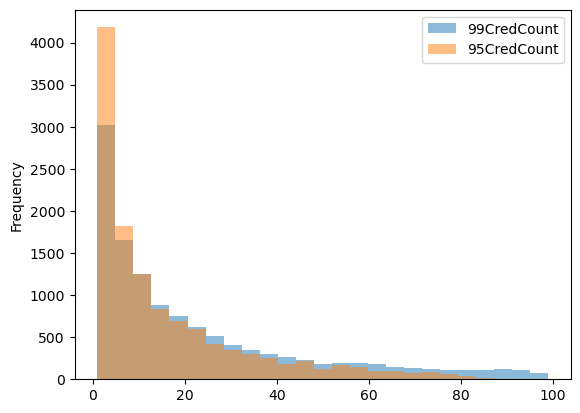

In [59]:
(
    picsed_df
    .filter(f.col("locus").isNotNull())
    .select(
        "studyId",
        "variantId",
        f.aggregate(
            f.transform(
                f.col("locus"),
                lambda locus: f.when(locus.is99CredibleSet, f.lit(1.0)).otherwise( f.lit(0.0))
            ),
            f.lit(0.0),
            lambda summa, value: summa + value
        ).alias("99CredCount"),
        f.aggregate(
            f.transform(
                f.col("locus"),
                lambda locus: f.when(locus.is95CredibleSet, f.lit(1.0)).otherwise( f.lit(0.0))
            ),
            f.lit(0.0),
            lambda summa, value: summa + value
        ).alias("95CredCount"),
    )
#     .orderBy(f.col('99CredCount').desc())
#     .show()
    .filter(f.col("99CredCount") < 100)
#     .count()
    .toPandas()
    [["99CredCount", "95CredCount"]]
    .plot.hist(bins=25, alpha=0.5, label="Credible set size")
)

## Finngen clumping with locus

- Window width: 500kbp
- Locus width: 250kbp
- LD threshold: 0.5



In [2]:
# Import:
from pyspark.sql import functions as f

from gentropy.common.session import Session
from gentropy.dataset.ld_index import LDIndex
from gentropy.dataset.study_index import StudyIndex
from gentropy.dataset.study_locus import StudyLocus
from gentropy.dataset.summary_statistics import SummaryStatistics
from gentropy.method.ld import LDAnnotator
from gentropy.method.pics import PICS

# Initialize session:
session = Session()

# Input:
sumstats = "gs://genetics_etl_python_playground/output/python_etl/parquet/XX.XX/preprocess/finngen/summary_stats/*"
ld_index_path = "gs://genetics_etl_python_playground/output/python_etl/parquet/XX.XX/ld_index/"

# Output:
ld_clumped_output = "gs://ot-team/dsuveges/finngen/2023.10.06_LD_clumped"
picsed_output = "gs://ot-team/dsuveges/finngen/2023.10.06_PICSed"
window_based_clumped_output = "gs://ot-team/dsuveges/finngen/2023.10.06_window_clumped"

In [16]:
window_based_clumped_output = "gs://ot-team/dsuveges/finngen/2023.10.13_window_clumped_w_locus"

clump_window_length = 500_000
locus_window_length = 250_000

(
    SummaryStatistics(
        _df=(
            session.spark.read.parquet(sumstats, recursiveFileLookup=True)
            .withColumn(
                "chromosome",
                f.split(f.col("variantId"), "_")[0]
            )
        ),
        _schema=SummaryStatistics.get_schema()
    )
    .window_based_clumping(
        distance=clump_window_length,
        locus_collect_distance=locus_window_length,
        with_locus=True
    )
    .df.write.mode("overwrite")
    .parquet(window_based_clumped_output)
)


23/10/13 10:47:53 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build right for right outer join.
23/10/13 10:47:53 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
23/10/13 10:48:19 WARN GhfsStorageStatistics: Detected potential high latency for operation stream_read_operations. latencyMs=1248; previousMaxLatencyMs=1230; operationCount=59116581; context=gs://genetics_etl_python_playground/output/python_etl/parquet/XX.XX/preprocess/finngen/summary_stats/FINNGEN_R9_OTHER_SYSTCON_FG/chromosome=2/part-00019-1d683f00-9247-401b-846c-8b2498bc68bf.c000.snappy.parquet
23/10/13 10:49:02 WARN GhfsStorageStatistics: Detected potential high latency for operation op_get_file_status. latencyMs=1039; previousMaxLatencyMs=1037; operationCount=126124; context=gs://genetics_etl_python_playground/output/python_etl/parquet/XX.XX/preprocess/finngen/summary_stats/

In [18]:
ld_clumped_output = "gs://ot-team/dsuveges/finngen/2023.10.13_ld_clumped_w_locus"

studies_df = (
    session.spark.read.parquet(window_based_clumped_output)
    # Generating a list of study identifiers:
    .select("studyId")
    .distinct()
    # Adding fabricated values required to parse as gwas catalog study:
    .select(
        "studyId",
        StudyIndex.aggregate_and_map_ancestries(
            f.array(
                f.struct(
                    f.lit("Finnish").alias("ancestry"),
                    f.lit(100).cast("long").alias("sampleSize")
                )
            )
        ).alias("ldPopulationStructure"),
        f.lit("FINNGEN").alias("projectId"),
        f.lit("gwas").alias("studyType"),
        f.lit("cicaful").alias("traitFromSource")
    )
)

study_index = (
    StudyIndex(
        _df=studies_df,
        _schema=StudyIndex.get_schema()
    )
)

study_index.df.show()

# Loading ld index:
ld_index = LDIndex.from_parquet(session, ld_index_path)

(
    # To annotate study/locus, study level info and ld panel is needed:
    LDAnnotator.ld_annotate(
        StudyLocus.from_parquet(session, window_based_clumped_output),
        study_index,
        ld_index
    )
    # Clumping linked study-loci together:
    .clump()
    .df.write.mode("overwrite").parquet(ld_clumped_output)
)




+--------------------+---------------------+---------+---------+---------------+
|             studyId|ldPopulationStructure|projectId|studyType|traitFromSource|
+--------------------+---------------------+---------+---------+---------------+
|FINNGEN_R9_K11_EN...|         [{fin, 1.0}]|  FINNGEN|     gwas|        cicaful|
|FINNGEN_R9_H7_KER...|         [{fin, 1.0}]|  FINNGEN|     gwas|        cicaful|
|FINNGEN_R9_H8_EXT...|         [{fin, 1.0}]|  FINNGEN|     gwas|        cicaful|
|FINNGEN_R9_H7_RET...|         [{fin, 1.0}]|  FINNGEN|     gwas|        cicaful|
|FINNGEN_R9_RHEUMA...|         [{fin, 1.0}]|  FINNGEN|     gwas|        cicaful|
|FINNGEN_R9_H7_KER...|         [{fin, 1.0}]|  FINNGEN|     gwas|        cicaful|
|FINNGEN_R9_HEIGHT...|         [{fin, 1.0}]|  FINNGEN|     gwas|        cicaful|
|FINNGEN_R9_M13_SY...|         [{fin, 1.0}]|  FINNGEN|     gwas|        cicaful|
|FINNGEN_R9_M13_DO...|         [{fin, 1.0}]|  FINNGEN|     gwas|        cicaful|
|FINNGEN_R9_M13_PY...|      

23/10/13 11:55:34 WARN GhfsStorageStatistics: Detected potential high latency for operation op_open. latencyMs=676; previousMaxLatencyMs=470; operationCount=333148; context=gs://genetics_etl_python_playground/output/python_etl/parquet/XX.XX/ld_index/chromosome=5/part-00076-ff42773a-494c-46d2-bc22-322062b5e715.c000.snappy.parquet
23/10/13 12:39:11 WARN GhfsStorageStatistics: Detected potential high latency for operation op_create. latencyMs=279; previousMaxLatencyMs=243; operationCount=140; context=gs://ot-team/dsuveges/finngen/2023.10.13_ld_clumped_w_locus/_temporary/0/_temporary/attempt_202310131239103300432709600941830_0086_m_000000_80535/part-00000-17d449c4-f0c3-4617-b378-b74b864ab64a-c000.snappy.parquet
23/10/13 12:39:11 WARN GhfsStorageStatistics: Detected potential high latency for operation op_create. latencyMs=335; previousMaxLatencyMs=279; operationCount=140; context=gs://ot-team/dsuveges/finngen/2023.10.13_ld_clumped_w_locus/_temporary/0/_temporary/attempt_2023101312391064173

In [9]:
(
    session.spark.read.parquet(ld_clumped_output)
    .groupBy("qualityControls")
    .count()
#     .show(1, False, True)
    .show(truncate=False)
)

+--------------------------------------------------------------+-----+
|qualityControls                                               |count|
+--------------------------------------------------------------+-----+
|[Variant not found in LD reference]                           |4607 |
|[]                                                            |13813|
|[Explained by a more significant variant in high LD (clumped)]|585  |
+--------------------------------------------------------------+-----+



In [29]:
window_based_clumped_output = "gs://ot-team/dsuveges/finngen/2023.10.13_window_clumped_w_locus"

(
    session.spark.read.parquet(ld_clumped_output)
    .filter(f.size(f.col("qualityControls")) == 0)
#     .show(1, False, True)
    .select("locus", f.size(f.col("locus")).alias("size"))
    .limit(1)
    .collect()
)

[Row(locus=[Row(is95CredibleSet=None, is99CredibleSet=None, logABF=None, posteriorProbability=None, variantId='10_99764322_T_C', pValueMantissa=2.3949999809265137, pValueExponent=-3, pValueMantissaConditioned=None, pValueExponentConditioned=None, beta=-0.0201963, standardError=0.00665169, betaConditioned=None, standardErrorConditioned=None, r2Overall=None), Row(is95CredibleSet=None, is99CredibleSet=None, logABF=None, posteriorProbability=None, variantId='10_99764860_G_A', pValueMantissa=1.0499999523162842, pValueExponent=-3, pValueMantissaConditioned=None, pValueExponentConditioned=None, beta=0.00813303, standardError=0.00248194, betaConditioned=None, standardErrorConditioned=None, r2Overall=None), Row(is95CredibleSet=None, is99CredibleSet=None, logABF=None, posteriorProbability=None, variantId='10_99765280_C_T', pValueMantissa=7.499000072479248, pValueExponent=-4, pValueMantissaConditioned=None, pValueExponentConditioned=None, beta=-0.0147615, standardError=0.00437943, betaConditioned